## 0.1 Prepare Our Data for Kaggle

In [ ]:
!pip install gdown


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
!gdown --id 1rP-wZhkD15fQO3znAM0CprK63_QU3TpP

/usr/local/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1rP-wZhkD15fQO3znAM0CprK63_QU3TpP
From (redirected): https://drive.google.com/uc?id=1rP-wZhkD15fQO3znAM0CprK63_QU3TpP&confirm=t&uuid=33a662f0-01a4-43b7-8d1a-ed18dc11ec37
To: /kaggle/working/train_val_test.zip
100%|██████████████████████████████████████| 3.74G/3.74G [00:44<00:00, 83.4MB/s]


In [ ]:
import subprocess
import time
from tqdm import tqdm

In [ ]:
def show_progress_bar():
    print("\nExtracting files... Please wait.")
    for _ in tqdm(range(100), desc="Progress", bar_format="{l_bar}{bar:50}{r_bar}", colour="cyan"):
        time.sleep(0.02)  # Simulate progress

# Run the unzip command silently
subprocess.run("unzip -q /kaggle/working/train_val_test.zip", shell=True)

# Show the fancy progress bar
show_progress_bar()

print("\n✅ Extraction complete! 🚀")


Extracting files... Please wait.


Progress: 100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.22it/s]



✅ Extraction complete! 🚀


In [ ]:
! unzip /kaggle/working/train_val_test.zip

Archive:  /kaggle/working/train_val_test.zip
replace train/pins_Alexandra Daddario/Alexandra Daddario118_234_processed_0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## 0.2 📦 Install Essential Libraries

In [ ]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 48.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.6/306.6 kB 27.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# =============================== #
# 📌 Standard Library Imports
# =============================== #
import os
import sys
import glob
import shutil
import time
import datetime
import random
import warnings

# =============================== #
# 📌 Numerical & Data Handling
# =============================== #
import numpy as np
import pandas as pd

# =============================== #
# 📌 Image Processing Libraries
# =============================== #
import cv2
from PIL import Image

# =============================== #
# 📌 Deep Learning & Model Handling
# =============================== #
import tensorflow as tf
import tensorflow.lite as tflite
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ONNX Conversion Libraries
try:
    import onnx
except ImportError:
    print("Installing ONNX...")
    !pip install onnx
    import onnx

try:
    import tf2onnx
except ImportError:
    print("Installing tf2onnx...")
    !pip install tf2onnx
    import tf2onnx

# =============================== #
# 📌 Data Science & Visualization
# =============================== #
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# =============================== #
# 📌 Interactive & Console Utilities
# =============================== #
from IPython.display import display
from rich.console import Console
from rich.table import Table
from rich.progress import track
from rich import print as rprint
from tqdm import tqdm

# =============================== #
# 📌 PyTorch (For additional tasks)
# =============================== #
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# =============================== #
# 📌 Machine Learning Utilities
# =============================== #
from sklearn.model_selection import train_test_split

# =============================== #
# ⚠️ Suppress Warnings
# =============================== #
warnings.filterwarnings("ignore")


##  0.3 🎯 Setup TensorBoard

In [ ]:
def setup_tensorboard(log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))):
    try:
        print("\n📌 Setting up TensorBoard...")
        os.makedirs(log_dir, exist_ok=True)
        print("📊 TensorBoard initialized")
        return tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    except Exception as e:
        print(f"❌ Error setting up TensorBoard: {e}")

In [ ]:
InceptionV3_Writer = setup_tensorboard()


📌 Setting up TensorBoard...
📊 TensorBoard initialized


##  0.4 ⚙️ Setup the device

In [ ]:
def setup_device():
    try:
        device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
        print(f"⚙️ Running on: {device}")
        return device
    except Exception as e:
        print(f"❌ Error setting up device: {e}")


In [ ]:
device = setup_device()

⚙️ Running on: CPU


**Part 1: Face Detection and Dataset Preprocessing**
  * 1.1 Face Detection
    * Utilize OpenCV's DNN module for face detection.
    * Pre-trained face detection model files (.prototxt and .caffemodel) are required.
    * Confidence threshold set to 0.5.
    * Support for multiple face detections in an image.
  * 1.2 Dataset Preprocessing
    * Load the LFW dataset for face recognition.
    * Convert grayscale images to RGB and resize them to (299, 299) for compatibility with InceptionV3.
    * Normalize pixel values for consistent input processing.
    * Split the dataset into training (80%), validation (20% of training), and test (20%) sets.
    * Implement data augmentation techniques: rotation, width/height shifts, and horizontal flips.

This images has been collected from Pinterest and cropped. There are 105 celebrities and 17534 faces.

In [ ]:
from pathlib import Path
import torchvision

In [ ]:
output_file = Path("/kaggle/working")

In [ ]:
train_data_path = output_file/"train"
val_data_path = output_file/"val"
test_data_path = output_file/"test"

# Constants
IMG_SIZE = 229  # InceptionV3 input size
BATCH_SIZE = 32
NUM_WORKERS = 0



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Define parameters for InceptionV3
target_size = (299, 299)  # InceptionV3 input size
batch_size = 64

In [ ]:
# Define data augmentation with preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalize for InceptionV3
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    val_data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # No shuffling for test set
)
# Print dataset info
print(f"🔹 Train samples: {train_generator.samples}")
print(f"🔹 Validation samples: {val_generator.samples}")
print(f"🔹 Test samples: {test_generator.samples}")
print(f"🔹 Classes: {train_generator.class_indices}")
num_classes = train_generator.num_classes
print(f"🔹 Number Of Classes: {num_classes}")

Found 22491 images belonging to 105 classes.
Found 5581 images belonging to 105 classes.
Found 7144 images belonging to 105 classes.
🔹 Train samples: 22491
🔹 Validation samples: 5581
🔹 Test samples: 7144
🔹 Classes: {'pins_Adriana Lima': 0, 'pins_Alex Lawther': 1, 'pins_Alexandra Daddario': 2, 'pins_Alvaro Morte': 3, 'pins_Amanda Crew': 4, 'pins_Andy Samberg': 5, 'pins_Anne Hathaway': 6, 'pins_Anthony Mackie': 7, 'pins_Avril Lavigne': 8, 'pins_Ben Affleck': 9, 'pins_Bill Gates': 10, 'pins_Bobby Morley': 11, 'pins_Brenton Thwaites': 12, 'pins_Brian J. Smith': 13, 'pins_Brie Larson': 14, 'pins_Chris Evans': 15, 'pins_Chris Hemsworth': 16, 'pins_Chris Pratt': 17, 'pins_Christian Bale': 18, 'pins_Cristiano Ronaldo': 19, 'pins_Danielle Panabaker': 20, 'pins_Dominic Purcell': 21, 'pins_Dwayne Johnson': 22, 'pins_Eliza Taylor': 23, 'pins_Elizabeth Lail': 24, 'pins_Emilia Clarke': 25, 'pins_Emma Stone': 26, 'pins_Emma Watson': 27, 'pins_Gwyneth Paltrow': 28, 'pins_Henry Cavil': 29, 'pins_Hugh J

Labels Sample [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


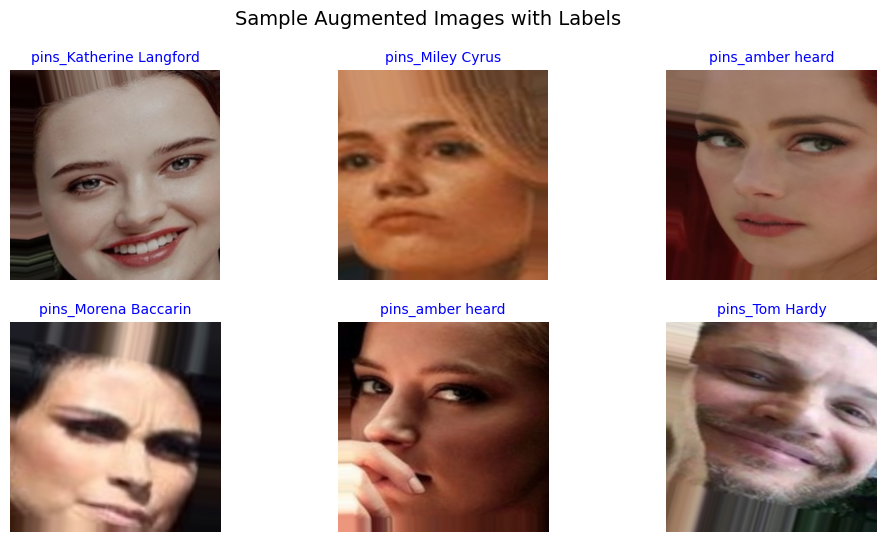

In [ ]:
def plot_images(generator, class_indices, num_images=6):
    """Plots sample images with labels from a data generator.

    Args:
        generator: The data generator (ImageDataGenerator flow).
        class_indices: Dictionary mapping class indices to labels.
        num_images: Number of images to display (default: 6).
    """
    images, labels = next(generator)  # Get a batch of images and labels
    print(f"Labels Sample {labels}")
    class_labels = {v: k for k, v in class_indices.items()}  # Reverse class mapping

    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        plt.imshow((images[i] + 1) / 2)  # Adjust image for display
        plt.axis("off")

        # Convert one-hot encoding to class label
        label_idx = np.argmax(labels[i])
        label_name = class_labels[label_idx]  # Get class name

        plt.title(label_name, fontsize=10, color="blue")  # Display class name

    plt.suptitle("Sample Augmented Images with Labels", fontsize=14)
    plt.show()

# Display sample images from training set
plot_images(train_generator, train_generator.class_indices)

In [ ]:
import torch
import cloudpickle # Import cloudpickle
print(cloudpickle.__version__)

3.1.1


# **Part 2: Face Recognition with Inception V3 Transfer Learning**
  - 2.1 Load and Modify Inception V3
    - Use TensorFlow/Keras Inception V3 with pre-trained weights on ImageNet.
    - Modify model architecture:
    - Add a Global Average Pooling layer.
    - Include a Dense layer (128 neurons, ReLU activation).
    - Apply Dropout (0.5) for regularization.
    - Use a final Dense layer with softmax activation for classification.
    - Freeze base model layers to retain pre-trained feature extraction.
  - 2.2 Training the Model
    - Optimizer: Adam with a learning rate of 0.001.
    - Loss function: Categorical crossentropy.
    - Metrics: Accuracy.
    - Implement callbacks:
    - Early stopping to monitor validation loss with a patience of 5 epochs.
    - Learning rate reduction upon validation loss plateau (factor 0.1, patience 3).
  - 2.3 Optimization Techniques
    - Convert and save the trained model in ONNX format.
    - Apply TensorFlow Lite (TFLite) quantization for efficient mobile deployment.
    - Extract feature embeddings from the trained model for similarity-based recognition.

## 2.1 Load and Modify Inception V3
  - Use TensorFlow/Keras Inception V3 with pre-trained weights on ImageNet.
  - Modify model architecture:
  - Add a Global Average Pooling layer.
  - Include a Dense layer (128 neurons, ReLU activation).
  - Apply Dropout (0.5) for regularization.
  - Use a final Dense layer with softmax activation for classification.
  - Freeze base model layers to retain pre-trained feature extraction.

In [ ]:
# Define the path
checkpoint_path = "/kaggle/working/models/InceptionV3_checkpoint.weights.h5"

## 2.2 Use Optuna to Build our Model

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2

def build_model(num_classes, checkpoint_path=None):
    """ Load InceptionV3 model and modify it for face classification. """

    print("\n🧠 Loading pre-trained InceptionV3 model...")
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    print("✅ Pre-trained model loaded successfully!")

    # 🔧 Fine-tune the top 20 layers instead of freezing all layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    print("✅ Fine-tuning applied to top layers!")

    # 🔹 Feature extraction
    x = GlobalAveragePooling2D()(base_model.output)

    # 🔹 Fully Connected Layers with Swish activation & L2 Regularization
    x = Dense(512, activation='swish', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='swish', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation='swish', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)

    # 🔹 AdamW Optimizer (Better generalization than SGD)
    optimizer = AdamW(learning_rate=0.0001, weight_decay=1e-5)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print("✅ Model architecture optimized successfully!")

    # 🔹 Load previous checkpoint if exists
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"\n🔄 Loading weights from checkpoint: {checkpoint_path}...")
        model.load_weights(checkpoint_path)
        print("✅ Checkpoint loaded successfully!")

    model.name = "InceptionV3_FaceRec"

    return model

# Build the optimized model
InceptionV3_model = build_model(num_classes)



🧠 Loading pre-trained InceptionV3 model...


I0000 00:00:1739748006.521116      10 service.cc:148] XLA service 0x56b983ec5720 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739748006.521170      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1739748006.521175      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1739748006.521178      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1739748006.521181      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1739748006.521183      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1739748006.521186      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1739748006.521189      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1739748006.521191      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
✅ Pre-trained model loaded successfully!
✅ Fine-tuning applied to top layers!
✅ Model architecture optimized successfully!


In [ ]:
def train_model(model, train_data, val_data, checkpoint_path, epochs=20):
    """ Train the model with data generators and callbacks. """
    print("\n🚀 Starting model training...")

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
        ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1),
        InceptionV3_Writer
    ]

    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=callbacks,verbose=1)
    print("✅ Model training completed!")
    return history


In [ ]:
InceptionV3_model.summary()

Model: "InceptionV3_FaceRec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 23,033,225 (87.86 MB)

 Trainable params: 3,164,009 (12.07 MB)

 Non-trainable params: 19,869,216 (75.80 MB)

## 2.2 Training the Model
  - Optimizer: Adam with a learning rate of 0.001.
  - Loss function: Categorical crossentropy.
  - Metrics: Accuracy.
  - Implement callbacks:
    - Early stopping to monitor validation loss with a patience of 5 epochs.
    - Learning rate reduction upon validation loss plateau (factor 0.1, patience 3).

In [ ]:
history1 = train_model(
    model = InceptionV3_model,
    train_data = train_generator,
    val_data=val_generator,
    checkpoint_path=checkpoint_path,
    epochs=50
)


🚀 Starting model training...
Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0189 - loss: 5.8049
Epoch 1: val_loss improved from inf to 4.86347, saving model to /kaggle/working/models/InceptionV3_checkpoint.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 556s 1s/step - accuracy: 0.0189 - loss: 5.8044 - val_accuracy: 0.0697 - val_loss: 4.8635 - learning_rate: 1.0000e-04
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0431 - loss: 5.1656
Epoch 2: val_loss improved from 4.86347 to 4.40032, saving model to /kaggle/working/models/InceptionV3_checkpoint.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - accuracy: 0.0432 - loss: 5.1654 - val_accuracy: 0.1312 - val_loss: 4.4003 - learning_rate: 1.0000e-04
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0737 - loss: 4.7750
Epoch 3: val_loss improved from 4.40032 to 4.14986, saving model to /kaggle/working/models/InceptionV3_checkpoint.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 485s 1s/step - accuracy

## 2.3 Plot the training metrics

In [ ]:
import plotly.graph_objects as go
def plot_training_metrics(history, model_name):
    """
    Plots training vs validation loss and accuracy curves.

    Parameters:
        history (tensorflow.python.keras.callbacks.History): Training history object.
        model_name (str): Name of the model.
    """
    # Convert history to DataFrame
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history_df.index + 1

    # Identify Overfitting Points
    overfitting_loss_epoch = history_df['val_loss'].idxmin() + 1
    overfitting_loss_value = history_df.loc[overfitting_loss_epoch - 1, 'val_loss']

    overfitting_acc_epoch = history_df['val_accuracy'].idxmax() + 1
    overfitting_acc_value = history_df.loc[overfitting_acc_epoch - 1, 'val_accuracy']

    # Create Subplots
    fig = go.Figure()

    # Loss Plot
    fig.add_trace(go.Scatter(x=history_df['epoch'], y=history_df['loss'],
                             mode='lines', name='Training Loss', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=history_df['epoch'], y=history_df['val_loss'],
                             mode='lines', name='Validation Loss', line=dict(color='red')))

    # Mark Overfitting Point for Loss
    fig.add_trace(go.Scatter(x=[overfitting_loss_epoch], y=[overfitting_loss_value],
                             mode='markers', name='Overfitting Point (Loss)',
                             marker=dict(color='red', size=10, symbol='x')))

    # Accuracy Plot
    fig.add_trace(go.Scatter(x=history_df['epoch'], y=history_df['accuracy'],
                             mode='lines', name='Training Accuracy', line=dict(color='green')))
    fig.add_trace(go.Scatter(x=history_df['epoch'], y=history_df['val_accuracy'],
                             mode='lines', name='Validation Accuracy', line=dict(color='orange')))

    # Mark Overfitting Point for Accuracy
    fig.add_trace(go.Scatter(x=[overfitting_acc_epoch], y=[overfitting_acc_value],
                             mode='markers', name='Best Validation Accuracy',
                             marker=dict(color='orange', size=10, symbol='diamond')))

    # Layout Settings
    fig.update_layout(
        title=f"Training & Validation Metrics ({model_name})",
        xaxis_title="Epochs",
        yaxis_title="Value",
        legend_title="Metrics",
        template="plotly_dark",
        title_x=0.5
    )

    fig.show()


In [ ]:
plot_training_metrics(history1,InceptionV3_model.name)

In [ ]:
# 🔹 Create directory for saving models
save_dir = "/kaggle/working/models"
os.makedirs(save_dir, exist_ok=True)

# 🔹 Save the full model in Keras format
keras_model_path = os.path.join(save_dir, "InceptionV3_model.keras")
InceptionV3_model.save(keras_model_path)
print(f"✅ Model saved in Keras format at: {keras_model_path}")

# 🔹 Save the full model in H5 format
h5_model_path = os.path.join(save_dir, "InceptionV3_model.h5")
InceptionV3_model.save(h5_model_path)
print(f"✅ Model saved in H5 format at: {h5_model_path}")

✅ Model saved in Keras format at: /kaggle/working/models/InceptionV3_model.keras
✅ Model saved in H5 format at: /kaggle/working/models/InceptionV3_model.h5


In [ ]:
from tensorflow.keras.models import load_model

# 🔹 Load the model from .keras format
loaded_model_keras = load_model("/kaggle/working/models/InceptionV3_model.keras")
print("✅ Keras model loaded successfully!")

# 🔹 Load the model from .h5 format
loaded_model_h5 = load_model("/kaggle/working/models/InceptionV3_model.h5")
print("✅ H5 model loaded successfully!")

# 🔹 Check model summary
loaded_model_keras.summary()

✅ Keras model loaded successfully!
✅ H5 model loaded successfully!


Model: "InceptionV3_FaceRec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 26,197,236 (99.93 MB)

 Trainable params: 3,164,009 (12.07 MB)

 Non-trainable params: 19,869,216 (75.80 MB)

 Optimizer params: 3,164,011 (12.07 MB)

## 2.4 Give a try for 10 more epoches

In [ ]:
history2 = train_model(
    model = InceptionV3_model,
    train_data = train_generator,
    val_data=val_generator,
    checkpoint_path=checkpoint_path,
    epochs=10
)


🚀 Starting model training...
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6625 - loss: 1.5776
Epoch 1: val_loss improved from inf to 1.81701, saving model to /kaggle/working/models/InceptionV3_checkpoint.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.6624 - loss: 1.5777 - val_accuracy: 0.6266 - val_loss: 1.8170 - learning_rate: 1.0000e-04
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6654 - loss: 1.5743
Epoch 2: val_loss improved from 1.81701 to 1.70857, saving model to /kaggle/working/models/InceptionV3_checkpoint.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.6654 - loss: 1.5743 - val_accuracy: 0.6454 - val_loss: 1.7086 - learning_rate: 1.0000e-04
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6804 - loss: 1.5098
Epoch 3: val_loss improved from 1.70857 to 1.68740, saving model to /kaggle/working/models/InceptionV3_checkpoint.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy

In [ ]:
# Try 15 more epoch
history3 = train_model(
    model = InceptionV3_model,
    train_data = train_generator,
    val_data=val_generator,
    checkpoint_path=checkpoint_path,
    epochs=15
)


🚀 Starting model training...
Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7326 - loss: 1.3020
Epoch 1: val_loss improved from inf to 1.49078, saving model to /kaggle/working/models/InceptionV3_checkpoint.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 483s 1s/step - accuracy: 0.7326 - loss: 1.3020 - val_accuracy: 0.6993 - val_loss: 1.4908 - learning_rate: 2.0000e-05
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7336 - loss: 1.2793
Epoch 2: val_loss improved from 1.49078 to 1.47584, saving model to /kaggle/working/models/InceptionV3_checkpoint.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step - accuracy: 0.7336 - loss: 1.2793 - val_accuracy: 0.7042 - val_loss: 1.4758 - learning_rate: 2.0000e-05
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7350 - loss: 1.2713
Epoch 3: val_loss improved from 1.47584 to 1.46951, saving model to /kaggle/working/models/InceptionV3_checkpoint.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy

## Model Training Observation:
- The model has achieved a final accuracy of `76.35%` with a validation accuracy of `71.33%`. While the results are promising, it is important to note that the model's performance could be further improved with additional training and optimizations.

- Due to limited GPU resources, the training was conducted on Kaggle with a restricted number of available hours. As a result, the training process was cut short after 15 epochs. With more GPU hours and additional epochs, there is a significant potential to improve the model's accuracy by refining the architecture, exploring hyperparameter tuning, and extending the training duration.

- Thus, while the current model demonstrates competent performance, there is still room for enhancement through continued training, resource allocation, and model tuning.


Optuna code to Optmize our model
```
def build_model(num_classes, num_trainable_layers, hidden_units, checkpoint_path=None):
    """ Load InceptionV3 model and modify it for face classification with optimal hyperparameters. """
    
    print("\n🧠 Loading pre-trained InceptionV3 model...")
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    print("✅ Pre-trained model loaded successfully!")
    
    # 🔧 Fine-tune the top 'num_trainable_layers' layers
    for layer in base_model.layers[:-num_trainable_layers]:
        layer.trainable = False
    print(f"✅ Fine-tuned top {num_trainable_layers} layers!")

    # 🔹 Feature extraction
    x = GlobalAveragePooling2D()(base_model.output)
    
    # 🔹 Fully Connected Layers with Swish activation & L2 Regularization
    x = Dense(hidden_units[0], activation='swish', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(hidden_units[1], activation='swish', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(hidden_units[2], activation='swish', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)

    # 🔹 AdamW Optimizer (Better generalization than SGD)
    optimizer = AdamW(learning_rate=0.0001, weight_decay=1e-5)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print("✅ Model architecture optimized successfully!")

    # 🔹 Load previous checkpoint if exists
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"\n🔄 Loading weights from checkpoint: {checkpoint_path}...")
        model.load_weights(checkpoint_path)
        print("✅ Checkpoint loaded successfully!")

    model.name = "InceptionV3_FaceRec"

    return model

def objective(trial):
    """ Objective function to optimize hyperparameters using Optuna. """
    
    
    # Suggest values for trainable layers and hidden units
    num_trainable_layers = trial.suggest_int("num_trainable_layers", 10, 50)  # Range for trainable layers
    hidden_units = [
        trial.suggest_int("hidden_units_1", 128, 1024, step=64),  # First hidden layer units
        trial.suggest_int("hidden_units_2", 128, 1024, step=64),  # Second hidden layer units
        trial.suggest_int("hidden_units_3", 128, 1024, step=64)   # Third hidden layer units
    ]
    
    model = build_model(num_classes=num_classes,
                        num_trainable_layers=num_trainable_layers,
                        hidden_units=hidden_units)

    # Train model
    history = train_model(
    model = model,
    train_data = train_generator,
    val_data=val_generator,
    checkpoint_path=checkpoint_path,
    epochs=50
)


# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best trial
best_trial = study.best_trial

print("Best trial:")
print(f"  Value: {best_trial.value}")
print(f"  Params: {best_trial.params}")
```

## 2.5 Save the model in onnx formate

In [ ]:
def save_model_onnx(model, output_path):
    """ Convert and save the trained model in ONNX format. """
    print("\n🔄 Converting model to ONNX format...")

    # Specify input signature explicitly
    input_signature = [tf.TensorSpec(shape=[None, 299, 299, 3], dtype=tf.float32, name='input_image')]

    # Convert to ONNX
    model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature)

    # ✅ Create a filename for your ONNX model within the directory
    onnx_file_path = os.path.join(output_path, "inceptionv3_model.onnx")

    with open(onnx_file_path, "wb") as f: # ✅ Use the complete file path
        f.write(model_proto.SerializeToString())
    print(f"✅ Model saved in ONNX format at {onnx_file_path}!")

In [ ]:
output_path = "/kaggle/working/models/"
save_model_onnx(InceptionV3_model,output_path=output_path)


🔄 Converting model to ONNX format...
✅ Model saved in ONNX format at /kaggle/working/models/inceptionv3_model.onnx!


## 2.6 Convert the model to tflite

In [ ]:
def convert_to_tflite(model, output_path):
    """ Convert and save the trained model in TFLite format for efficient mobile deployment. """
    print("\n📱 Converting model to TensorFlow Lite format...")
    converter = tflite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    # Create a filename for your TFLite model within the directory
    tflite_file_path = os.path.join(output_path, "inceptionv3_model.tflite")
    with open(tflite_file_path, "wb") as f: # Use the complete file path
        f.write(tflite_model)
    print(f"✅ Model saved in TensorFlow Lite format at {tflite_file_path}!")

In [ ]:
convert_to_tflite(InceptionV3_model,output_path=output_path)


📱 Converting model to TensorFlow Lite format...
Saved artifact at '/tmp/tmps5atp1q5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 105), dtype=tf.float32, name=None)
Captures:
  132126695430928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132126828909616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132126828910496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132126828908032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132126828916656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132126828916832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132126828917008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132126828914368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132126828920528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132126829137408: TensorSpec(shape

In [ ]:
# =============================== #
# 📌 Standard Library Imports
# =============================== #
import os
import sys
import glob
import shutil
import time
import datetime
import random
import warnings

# =============================== #
# 📌 Numerical & Data Handling
# =============================== #
import numpy as np
import pandas as pd

# =============================== #
# 📌 Image Processing Libraries
# =============================== #
import cv2
from PIL import Image

# =============================== #
# 📌 Deep Learning & Model Handling
# =============================== #
import tensorflow as tf
import tensorflow.lite as tflite
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ONNX Conversion Libraries
try:
    import onnx
except ImportError:
    print("Installing ONNX...")
    !pip install onnx
    import onnx

try:
    import tf2onnx
except ImportError:
    print("Installing tf2onnx...")
    !pip install tf2onnx
    import tf2onnx

# =============================== #
# 📌 Data Science & Visualization
# =============================== #
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# =============================== #
# 📌 Interactive & Console Utilities
# =============================== #
from IPython.display import display
from rich.console import Console
from rich.table import Table
from rich.progress import track
from rich import print as rprint
from tqdm import tqdm

# =============================== #
# 📌 PyTorch (For additional tasks)
# =============================== #
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# =============================== #
# 📌 Machine Learning Utilities
# =============================== #
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm  # Progress bar
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from pathlib import Path
try:
  import onnxruntime as ort
  print("✅ ONNX Runtime imported successfully!")
except:
  print("❌ ONNX Runtime not imported!")
  !pip install onnxruntime
  import onnxruntime as ort
  print("✅ ONNX Runtime imported successfully!")
#import classification report
from sklearn.metrics import classification_report, confusion_matrix
import plotly.graph_objects as go

# =============================== #
# ⚠️ Suppress Warnings
# =============================== #
warnings.filterwarnings("ignore")

✅ ONNX Runtime imported successfully!


In [ ]:
# Define parameters for InceptionV3
target_size = (299, 299)  # InceptionV3 input size
batch_size = 64

In [ ]:
output_file = Path("/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/data/train_val_test")
train_data_path = output_file/"train"
val_data_path = output_file/"val"
test_data_path = output_file/"test"

In [ ]:
# Define data augmentation with preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalize for InceptionV3
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    val_data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # No shuffling for test set
)
# Print dataset info
print(f"🔹 Train samples: {train_generator.samples}")
print(f"🔹 Validation samples: {val_generator.samples}")
print(f"🔹 Test samples: {test_generator.samples}")
print(f"🔹 Classes: {train_generator.class_indices}")
num_classes = train_generator.num_classes
print(f"🔹 Number Of Classes: {num_classes}")

# Print Trst dataset info
print(f"🔹 Test samples: {test_generator.samples}")
print(f"🔹 Classes: {test_generator.class_indices}")
num_classes = test_generator.num_classes
print(f"🔹 Number Of Classes: {num_classes}")
print(f"🔹 No of batches in test_generator : {len(test_generator)}")

Found 22491 images belonging to 105 classes.
Found 5581 images belonging to 105 classes.
Found 7144 images belonging to 105 classes.
🔹 Train samples: 22491
🔹 Validation samples: 5581
🔹 Test samples: 7144
🔹 Classes: {'pins_Adriana Lima': 0, 'pins_Alex Lawther': 1, 'pins_Alexandra Daddario': 2, 'pins_Alvaro Morte': 3, 'pins_Amanda Crew': 4, 'pins_Andy Samberg': 5, 'pins_Anne Hathaway': 6, 'pins_Anthony Mackie': 7, 'pins_Avril Lavigne': 8, 'pins_Ben Affleck': 9, 'pins_Bill Gates': 10, 'pins_Bobby Morley': 11, 'pins_Brenton Thwaites': 12, 'pins_Brian J. Smith': 13, 'pins_Brie Larson': 14, 'pins_Chris Evans': 15, 'pins_Chris Hemsworth': 16, 'pins_Chris Pratt': 17, 'pins_Christian Bale': 18, 'pins_Cristiano Ronaldo': 19, 'pins_Danielle Panabaker': 20, 'pins_Dominic Purcell': 21, 'pins_Dwayne Johnson': 22, 'pins_Eliza Taylor': 23, 'pins_Elizabeth Lail': 24, 'pins_Emilia Clarke': 25, 'pins_Emma Stone': 26, 'pins_Emma Watson': 27, 'pins_Gwyneth Paltrow': 28, 'pins_Henry Cavil': 29, 'pins_Hugh J

In [ ]:
# Load the model
h5_model_path = r"/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/models/InceptionV3_model.h5"
keras_model_path = r"/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/models/InceptionV3_model.keras"
onnx_model_path = r"/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/models/inceptionv3_model.onnx"
tflite_model_path = r"/content/drive/MyDrive/Sprints task/Capstone_Project/04_Capstone Project_Deep Learning Project/models/inceptionv3_model.tflite"
model_h5 = tf.keras.models.load_model(h5_model_path)
model_keras = tf.keras.models.load_model(keras_model_path)
model_onnx = onnx.load(onnx_model_path)
model_tflite = tf.lite.Interpreter(model_path=tflite_model_path)

In [ ]:
class_names = {
    'pins_Adriana Lima': 0, 'pins_Alex Lawther': 1, 'pins_Alexandra Daddario': 2, 'pins_Alvaro Morte': 3, 'pins_Amanda Crew': 4,
    'pins_Andy Samberg': 5, 'pins_Anne Hathaway': 6, 'pins_Anthony Mackie': 7, 'pins_Avril Lavigne': 8, 'pins_Ben Affleck': 9,
    'pins_Bill Gates': 10, 'pins_Bobby Morley': 11, 'pins_Brenton Thwaites': 12, 'pins_Brian J. Smith': 13, 'pins_Brie Larson': 14,
    'pins_Chris Evans': 15, 'pins_Chris Hemsworth': 16, 'pins_Chris Pratt': 17, 'pins_Christian Bale': 18, 'pins_Cristiano Ronaldo': 19,
    'pins_Danielle Panabaker': 20, 'pins_Dominic Purcell': 21, 'pins_Dwayne Johnson': 22, 'pins_Eliza Taylor': 23, 'pins_Elizabeth Lail': 24,
    'pins_Emilia Clarke': 25, 'pins_Emma Stone': 26, 'pins_Emma Watson': 27, 'pins_Gwyneth Paltrow': 28, 'pins_Henry Cavil': 29,
    'pins_Hugh Jackman': 30, 'pins_Inbar Lavi': 31, 'pins_Irina Shayk': 32, 'pins_Jake Mcdorman': 33, 'pins_Jason Momoa': 34,
    'pins_Jennifer Lawrence': 35, 'pins_Jeremy Renner': 36, 'pins_Jessica Barden': 37, 'pins_Jimmy Fallon': 38, 'pins_Johnny Depp': 39,
    'pins_Josh Radnor': 40, 'pins_Katharine Mcphee': 41, 'pins_Katherine Langford': 42, 'pins_Keanu Reeves': 43, 'pins_Krysten Ritter': 44,
    'pins_Leonardo DiCaprio': 45, 'pins_Lili Reinhart': 46, 'pins_Lindsey Morgan': 47, 'pins_Lionel Messi': 48, 'pins_Logan Lerman': 49,
    'pins_Madelaine Petsch': 50, 'pins_Maisie Williams': 51, 'pins_Maria Pedraza': 52, 'pins_Marie Avgeropoulos': 53, 'pins_Mark Ruffalo': 54,
    'pins_Mark Zuckerberg': 55, 'pins_Megan Fox': 56, 'pins_Miley Cyrus': 57, 'pins_Millie Bobby Brown': 58, 'pins_Morena Baccarin': 59,
    'pins_Morgan Freeman': 60, 'pins_Nadia Hilker': 61, 'pins_Natalie Dormer': 62, 'pins_Natalie Portman': 63, 'pins_Neil Patrick Harris': 64,
    'pins_Pedro Alonso': 65, 'pins_Penn Badgley': 66, 'pins_Rami Malek': 67, 'pins_Rebecca Ferguson': 68, 'pins_Richard Harmon': 69,
    'pins_Rihanna': 70, 'pins_Robert De Niro': 71, 'pins_Robert Downey Jr': 72, 'pins_Sarah Wayne Callies': 73, 'pins_Selena Gomez': 74,
    'pins_Shakira Isabel Mebarak': 75, 'pins_Sophie Turner': 76, 'pins_Stephen Amell': 77, 'pins_Taylor Swift': 78, 'pins_Tom Cruise': 79,
    'pins_Tom Hardy': 80, 'pins_Tom Hiddleston': 81, 'pins_Tom Holland': 82, 'pins_Tuppence Middleton': 83, 'pins_Ursula Corbero': 84,
    'pins_Wentworth Miller': 85, 'pins_Zac Efron': 86, 'pins_Zendaya': 87, 'pins_Zoe Saldana': 88, 'pins_alycia dabnem carey': 89,
    'pins_amber heard': 90, 'pins_barack obama': 91, 'pins_barbara palvin': 92, 'pins_camila mendes': 93, 'pins_elizabeth olsen': 94,
    'pins_ellen page': 95, 'pins_elon musk': 96, 'pins_gal gadot': 97, 'pins_grant gustin': 98, 'pins_jeff bezos': 99, 'pins_kiernen shipka': 100,
    'pins_margot robbie': 101, 'pins_melissa fumero': 102, 'pins_scarlett johansson': 103, 'pins_tom ellis': 104
}

In [ ]:
def evaluate_model(model, test_generator, class_names):
    """
    Evaluates the model using a test data generator and prints performance metrics.

    Args:
        model: Trained Keras model.
        test_generator: Test data generator (flow_from_directory).
        class_names: List of class labels.

    Prints:
        - Accuracy, Weighted Precision, Recall, F1 Score
        - Classification Report
        - Confusion Matrix
        - Intermediate results every 25% of total batches
    """
    print("\n🚀 **Starting Model Evaluation...**\n")

    # Reset the generator to ensure we start from the first batch
    test_generator.reset()

    y_true = []
    y_pred = []

    total_batches = len(test_generator)
    quarter_batches = total_batches // 4  # Calculate 25% of the batches

    print(f"Total batches in test set: {total_batches}")

    try:
        for i, (images, labels) in enumerate(tqdm(test_generator, total=total_batches, desc="🔄 Evaluating Batches", unit="batch", leave=True)):
            preds = model.predict(images, verbose=0)  # Suppress TensorFlow's built-in progress bar
            y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot encoded labels to class indices
            y_pred.extend(np.argmax(preds, axis=1))   # Get predicted class indices

            # Print evaluation progress every 25% of the batches
            if (i + 1) % quarter_batches == 0 or i == total_batches - 1:
                print(f"\n🔎 Progress Update: {((i + 1) / total_batches) * 100:.0f}% completed\n")
                accuracy = accuracy_score(y_true, y_pred)
                precision = precision_score(y_true, y_pred, average='weighted')
                recall = recall_score(y_true, y_pred, average='weighted')
                f1 = f1_score(y_true, y_pred, average='weighted')

                print(f"🎯 **Accuracy**: {accuracy:.4f} ✅")
                print(f"📍 **Weighted Precision**: {precision:.4f} 🎯")
                print(f"📊 **Weighted Recall**: {recall:.4f} 🔄")
                print(f"🏆 **Weighted F1 Score**: {f1:.4f} ⭐\n")

            # Ensure we stop at exactly total_batches
            if i >= total_batches - 1:
                break

    except StopIteration:
        print("\n⚠️ End of dataset reached earlier than expected.\n")

    # Final Evaluation
    print("\n📌 **Final Performance Metrics**:\n")
    print(f"🎯 **Final Accuracy**: {accuracy:.4f} ✅")
    print(f"📍 **Final Weighted Precision**: {precision:.4f} 🎯")
    print(f"📊 **Final Weighted Recall**: {recall:.4f} 🔄")
    print(f"🏆 **Final Weighted F1 Score**: {f1:.4f} ⭐\n")

    # Display Detailed Classification Report
    print("📜 **Final Classification Report:**\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    print("\n🎨 **Plotting Confusion Matrix...**\n")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("🔮 Predicted Labels")
    plt.ylabel("🔍 Actual Labels")
    plt.title("📊 Confusion Matrix")
    plt.show()

    print("✅ **Model evaluation completed successfully!** 🎉🚀")


🚀 **Starting Model Evaluation...**

Total batches in test set: 112


🔄 Evaluating Batches:  25%|██▌       | 28/112 [14:56<51:40, 36.91s/batch]


🔎 Progress Update: 25% completed

🎯 **Accuracy**: 0.6892 ✅
📍 **Weighted Precision**: 0.8981 🎯
📊 **Weighted Recall**: 0.6892 🔄
🏆 **Weighted F1 Score**: 0.7731 ⭐



🔄 Evaluating Batches:  50%|█████     | 56/112 [26:33<20:52, 22.37s/batch]


🔎 Progress Update: 50% completed

🎯 **Accuracy**: 0.6970 ✅
📍 **Weighted Precision**: 0.8289 🎯
📊 **Weighted Recall**: 0.6970 🔄
🏆 **Weighted F1 Score**: 0.7520 ⭐



🔄 Evaluating Batches:  75%|███████▌  | 84/112 [38:10<10:19, 22.13s/batch]


🔎 Progress Update: 75% completed

🎯 **Accuracy**: 0.6972 ✅
📍 **Weighted Precision**: 0.7590 🎯
📊 **Weighted Recall**: 0.6972 🔄
🏆 **Weighted F1 Score**: 0.7222 ⭐



🔄 Evaluating Batches:  99%|█████████▉| 111/112 [52:06<00:28, 28.17s/batch]


🔎 Progress Update: 100% completed

🎯 **Accuracy**: 0.6968 ✅
📍 **Weighted Precision**: 0.6999 🎯
📊 **Weighted Recall**: 0.6968 🔄
🏆 **Weighted F1 Score**: 0.6950 ⭐


📌 **Final Performance Metrics**:

🎯 **Final Accuracy**: 0.6968 ✅
📍 **Final Weighted Precision**: 0.6999 🎯
📊 **Final Weighted Recall**: 0.6968 🔄
🏆 **Final Weighted F1 Score**: 0.6950 ⭐

📜 **Final Classification Report:**

                             precision    recall  f1-score   support

          pins_Adriana Lima       0.69      0.73      0.71        86
          pins_Alex Lawther       0.76      0.76      0.76        62
    pins_Alexandra Daddario       0.89      0.90      0.90        90
          pins_Alvaro Morte       0.77      0.75      0.76        57
           pins_Amanda Crew       0.62      0.69      0.65        48
          pins_Andy Samberg       0.72      0.79      0.75        81
         pins_Anne Hathaway       0.74      0.77      0.76        83
        pins_Anthony Mackie       0.92      0.90      0.91    

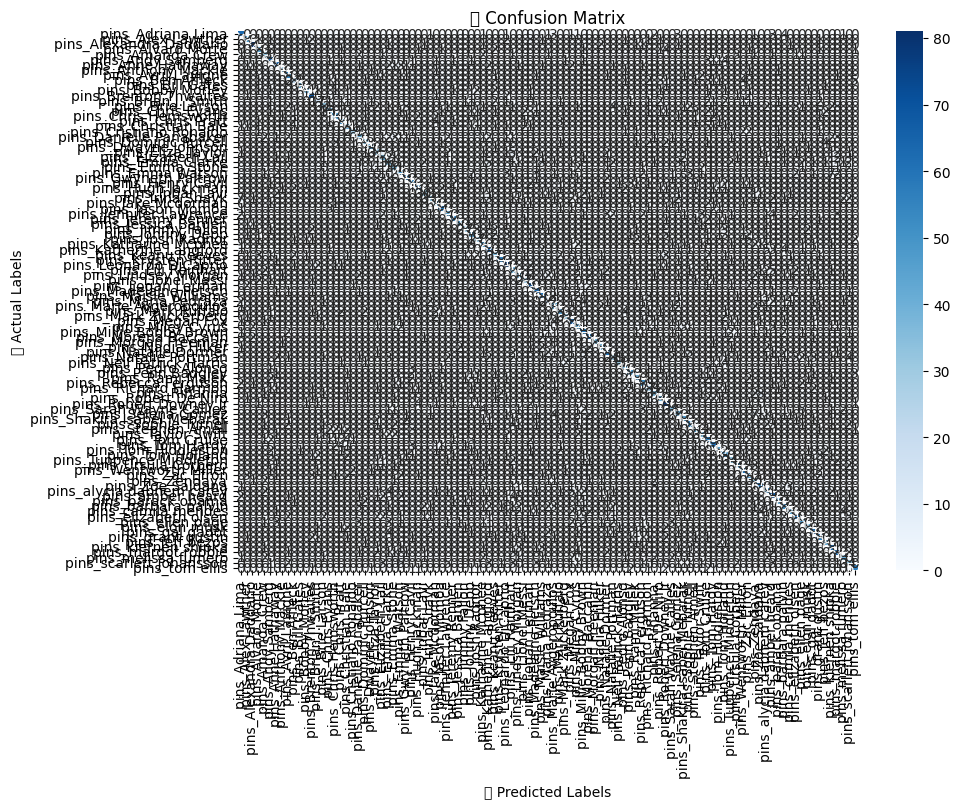

In [ ]:
evaluate_model(model_keras,test_generator,class_names)

##2.7 Plot some True and Wrong Predictions

In [ ]:
def plot_predictions(model, test_data, class_names, n_samples=5):
    """
    Plots correctly and incorrectly classified images using Matplotlib.

    Args:
        model: Trained model for predictions.
        test_data: Data generator containing images and labels.
        class_names: Dictionary of class names with integer labels as values.
        n_samples: Number of correctly and incorrectly classified images to display.
    """
    print("\n📸 Plotting model predictions...")

    # Reverse the dictionary to map integer labels to class names
    class_names_reversed = {v: k for k, v in class_names.items()}

    true_preds = []  # Store correctly predicted images
    false_preds = []  # Store incorrectly predicted images

    for images, labels in test_data:
        preds = model.predict(images)
        predicted_labels = np.argmax(preds, axis=1)

        for i in range(len(images)):
            # Convert one-hot encoding to scalar labels
            true_label = np.argmax(labels[i])  # One-hot to scalar
            pred_label = predicted_labels[i]
            img = images[i]

            if true_label == pred_label:
                true_preds.append((img, true_label, pred_label))
            else:
                false_preds.append((img, true_label, pred_label))

            # Stop if we have enough samples
            if len(true_preds) >= n_samples and len(false_preds) >= n_samples:
                break
        if len(true_preds) >= n_samples and len(false_preds) >= n_samples:
            break

    # Convert images to format suitable for plotting
    def convert_images(data_list):
        return [
            (img, true, pred) for img, true, pred in data_list
        ]

    true_images = convert_images(true_preds[:n_samples])
    false_images = convert_images(false_preds[:n_samples])

    # Create subplots for images
    fig, axes = plt.subplots(2, n_samples, figsize=(25, 12))

    # ✅ Plot correctly predicted images (Green)
    for i, (img, true, pred) in enumerate(true_images):
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Pred: {class_names_reversed[pred]} | True: {class_names_reversed[true]}")

    # ❌ Plot incorrectly predicted images (Red)
    for i, (img, true, pred) in enumerate(false_images):
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Pred: {class_names_reversed[pred]} | True: {class_names_reversed[true]}")

    plt.tight_layout()
    plt.suptitle("🔍 Model Predictions", fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()
    print("✅ Prediction visualization complete!")



📸 Plotting model predictions...
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 9s/step


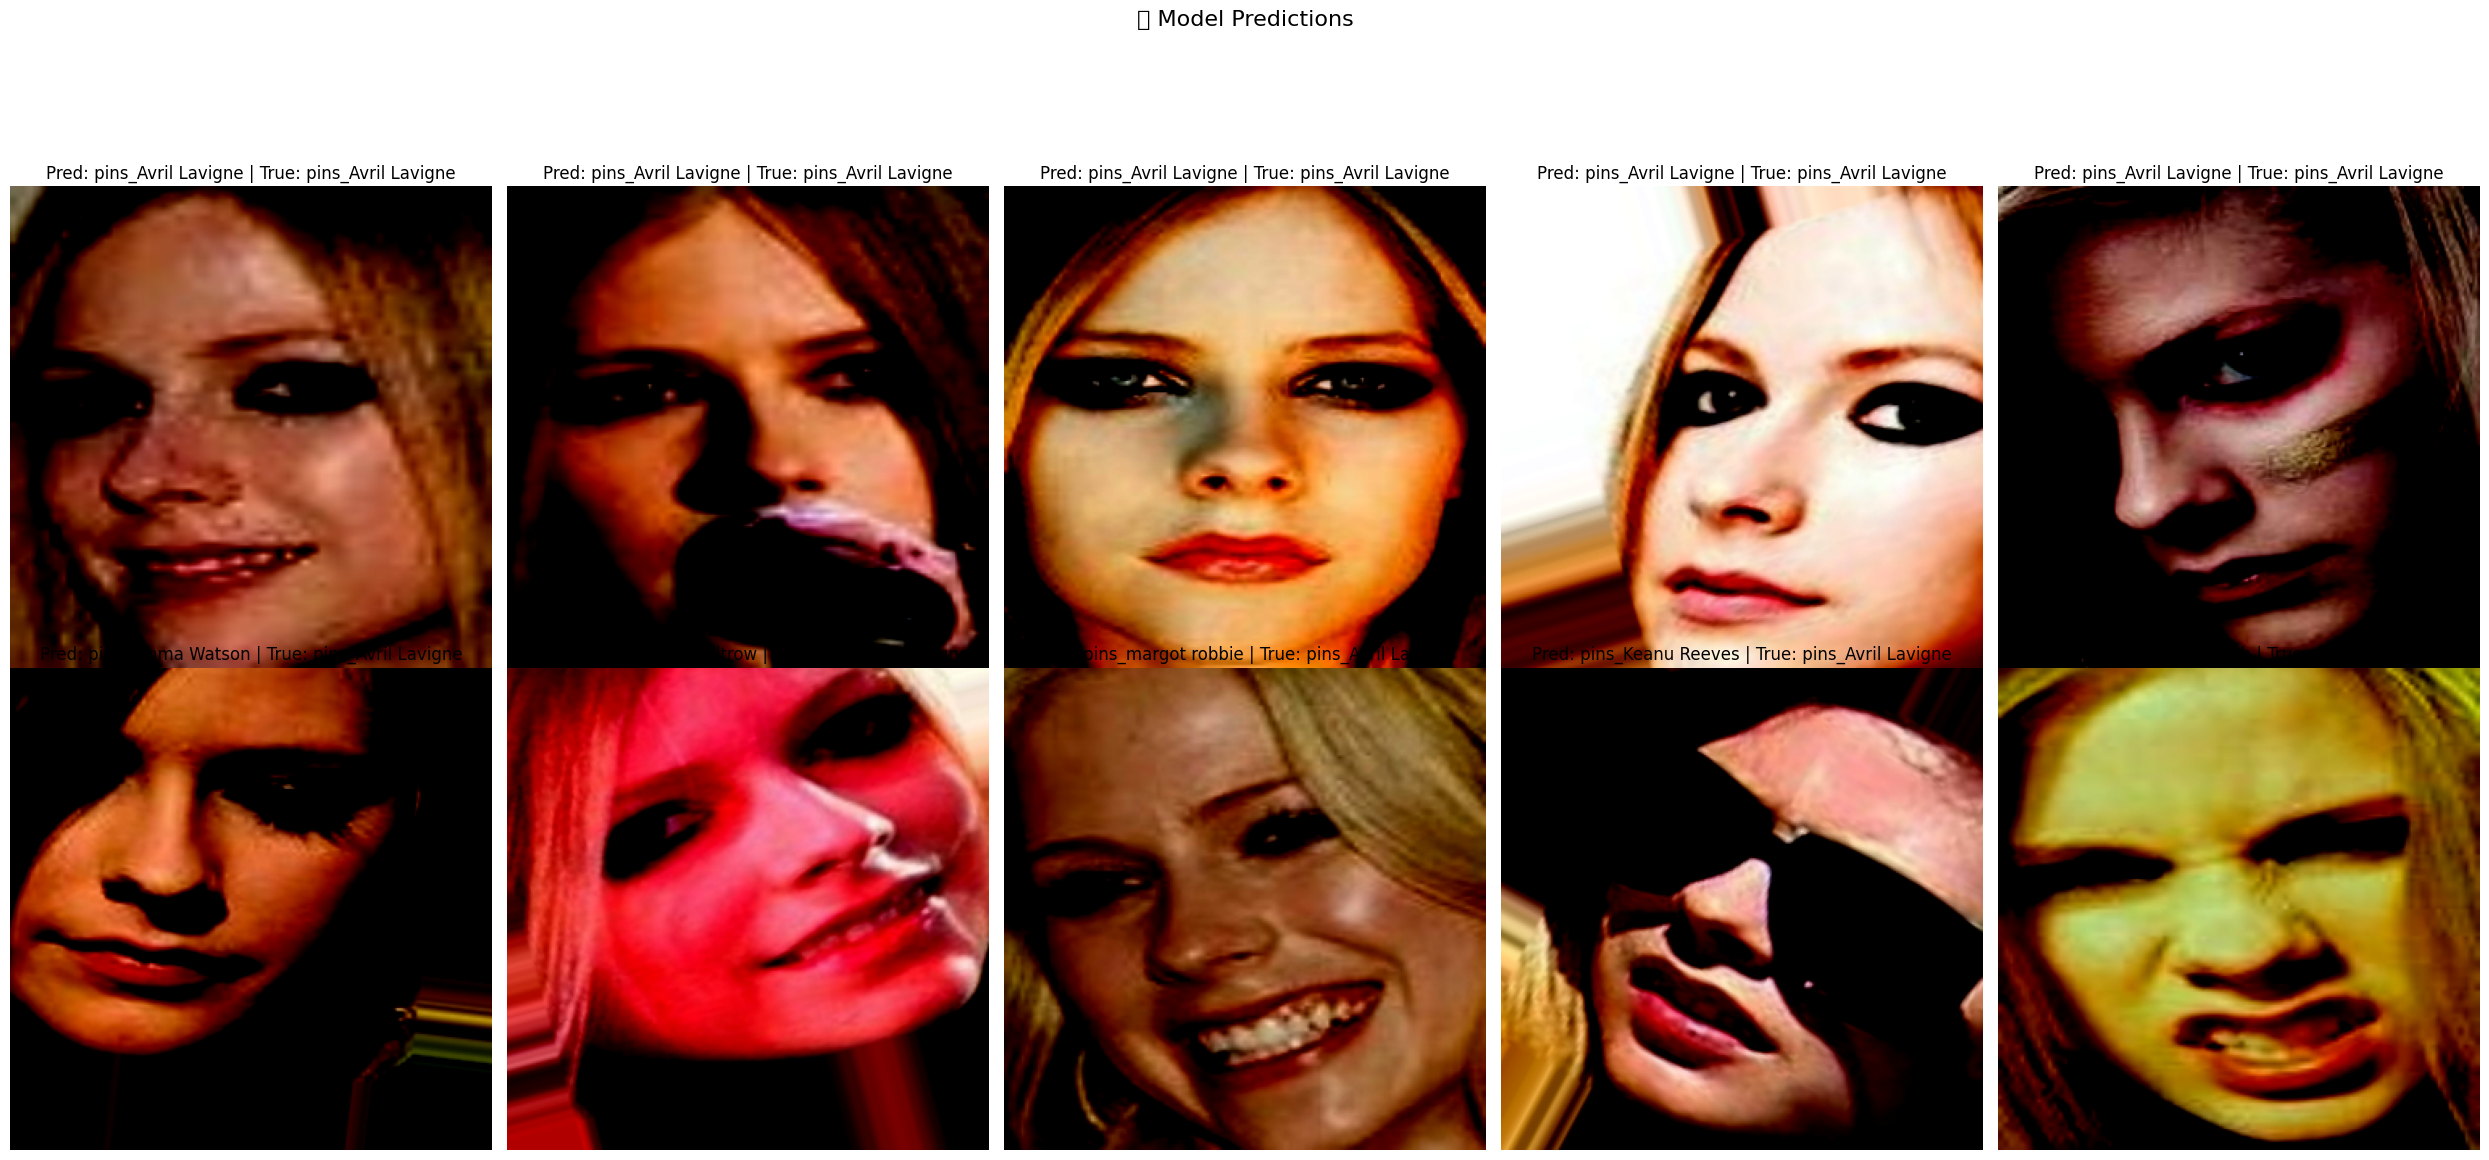

✅ Prediction visualization complete!


In [ ]:
# Call the function with your model and test generator
plot_predictions(model_keras, test_generator, class_names, n_samples=5)

In [ ]:
def compare_models(models):
    print("🚀 **Model Comparison Starts!** 🚀\n")

    # Function to check the file size of the models
    def get_model_size(model_path):
        return os.path.getsize(model_path) / (1024 * 1024)  # in MB

    # Function to get inference time for TensorFlow models
    def get_inference_time_tf(model, input_data):
        start_time = time.time()
        preds = model.predict(input_data, verbose=0)
        return time.time() - start_time

    # Function to get inference time for ONNX model
    def get_inference_time_onnx(model, input_data):
        ort_session = ort.InferenceSession(model)
        inputs = {ort_session.get_inputs()[0].name: input_data}
        start_time = time.time()
        preds = ort_session.run(None, inputs)
        return time.time() - start_time

    # Function to get inference time for TFLite model
    def get_inference_time_tflite(model, input_data):
        input_details = model.get_input_details()
        output_details = model.get_output_details()
        model.allocate_tensors()
        start_time = time.time()
        model.set_tensor(input_details[0]['index'], input_data)
        model.invoke()
        preds = model.get_tensor(output_details[0]['index'])
        return time.time() - start_time

    # Prepare a sample input (random data or image) for testing inference times
    img_shape = (299, 299, 3)  # InceptionV3 input shape
    random_input = np.random.random(img_shape).astype(np.float32)

    print("📊 **Model Comparison Results** 📊")
    for model_name, model in models.items():
        model_path = model['path']
        model_size = get_model_size(model_path)

        # Print model details
        print(f"\n🔸 **{model_name}**:")
        print(f"   - Model Type: {model['type']}")
        print(f"   - Model Size: {model_size:.2f} MB")

        # Inference time measurement based on model type
        if model['type'] == 'TensorFlow/Keras':
            inference_time = get_inference_time_tf(model['model'], np.expand_dims(random_input, axis=0))
        elif model['type'] == 'ONNX':
            inference_time = get_inference_time_onnx(model_path, np.expand_dims(random_input, axis=0))
        elif model['type'] == 'TFLite':
            inference_time = get_inference_time_tflite(model['model'], np.expand_dims(random_input, axis=0))

        print(f"   - Inference Time: {inference_time:.5f} seconds")

    print("\n🎉 **Model Comparison Complete!** 🎉")


In [ ]:
models = {
    "H5 Model": {'model': model_h5, 'path': h5_model_path, 'type': 'TensorFlow/Keras'},
    "Keras Model": {'model': model_keras, 'path': keras_model_path, 'type': 'TensorFlow/Keras'},
    "ONNX Model": {'model': model_onnx, 'path': onnx_model_path, 'type': 'ONNX'},
    "TFLite Model": {'model': model_tflite, 'path': tflite_model_path, 'type': 'TFLite'}
}

# Call the function to compare models
compare_models(models)

🚀 **Model Comparison Starts!** 🚀

📊 **Model Comparison Results** 📊

🔸 **H5 Model**:
   - Model Type: TensorFlow/Keras
   - Model Size: 112.98 MB
   - Inference Time: 1.58387 seconds

🔸 **Keras Model**:
   - Model Type: TensorFlow/Keras
   - Model Size: 113.06 MB
   - Inference Time: 1.56625 seconds

🔸 **ONNX Model**:
   - Model Type: ONNX
   - Model Size: 87.79 MB
   - Inference Time: 0.30184 seconds

🔸 **TFLite Model**:
   - Model Type: TFLite
   - Model Size: 87.78 MB
   - Inference Time: 0.29470 seconds

🎉 **Model Comparison Complete!** 🎉


## 2.8 Observations on Model Performance and Storage Efficiency

The evaluation of four different model formats—H5, Keras, ONNX, and TFLite—reveals significant differences in model size and inference speed. Below is a detailed analysis of these findings:

1.  Model Size Comparison
- The Keras (.keras) and H5 (.h5) models have similar sizes (~113 MB), suggesting they store additional metadata, optimizer states, and training configurations
- ONNX and TFLite models are significantly smaller (~87.78 MB), showing a reduction of ~22% in storage footprint compared to Keras-based models. This is beneficial for memory-limited environments like mobile devices and embedded systems.
2.   Inference Time Comparison
- H5 and Keras models take approximately 1.58s and 1.56s per inference, indicating that TensorFlow’s full-stack implementation is not optimized for speed but rather for flexibility and training efficiency.
- ONNX significantly reduces inference time to 0.30s, making it nearly 5 times faster than Keras. ONNX is designed for cross-platform efficiency, supporting inference acceleration through libraries like ONNX Runtime.
- TFLite is the fastest, with 0.29s inference time, showing an almost 5.4x speed-up over H5/Keras. This confirms that TFLite is highly optimized for low-latency applications.

📌 Applications & When to Use Each Model Format

|Model Format|Best Used For|Advantages|Limitations|
|------------|-------------|----------|-----------|
|H5 (.h5)|✅ Model training, checkpointing, and saving full Keras models|- Stores full Keras model (architecture, weights, optimizer state)|- Large file size|
|   |   |- Supports model re-training & fine-tuning|- Slow inference speed|
|Keras (.keras)|✅ Same as H5, recommended for latest TensorFlow versions|- Newer standard for saving Keras models| Same limitations as H5 (storage & speed)|
| | |- More future-proof with TensorFlow 2.x|
|ONNX (.onnx)|✅ Cross-platform deployment (Windows/Linux/Cloud)|- 22% smaller size than H5|- Requires conversion from TensorFlow/Keras|
| |✅ Running models on PyTorch, TensorFlow, Caffe| -5x faster inference|- Not suitable for mobile/embedded deployment|
| |✅ Accelerating inference via ONNX Runtime|- Compatible with multiple frameworks|  |
|TFLite (.tflite)|✅ Mobile apps (Android, iOS)|- Smallest size & lowest latency|- Not suitable for training|
| |✅ Edge AI (Raspberry Pi, Jetson Nano, Microcontrollers)|- Works with TensorFlow Lite Interpreter|- Limited support for complex architectures|
| |✅ Optimized inference on CPUs/TPUs|- Hardware acceleration support (Edge TPU, NNAPI)| |